# Today's topics
We will try to find out which phenotypic traits are associated with genetic markers in the BXD mouse population. This will allow us to make statements about the level of heritability of several traits as well as help us identify candidate genes responsible for specific traits.

There are several types of studies relevant in this context:

* Single gene association studies
* Genome wide association studies
* Phenome wide association studies

# GWAS background

http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2736153/ contains information about how to use genenetwork.org to find coat color phenotype and correlate that to expression levels

# Useful Resources

## Packages

### R
* [Matrix eQTL](http://www.bios.unc.edu/research/genomic_software/Matrix_eQTL/)
* [GWAS Tools](http://bioconductor.org/packages/release/bioc/html/GWASTools.html)
* [GenABEL](http://www.genabel.org/)


### Python
* [llmlite](http://kbroman.org/lmmlite/assets/compare2pylmm.html)
* [pylmm](http://genetics.cs.ucla.edu/pylmm/)
* [fstlmm](http://lomereiter.github.io/2015/02/16/lmm_cov.html)
* [pyGWAS](https://github.com/timeu/PyGWAS)
* [krux](https://github.com/tmichoel/krux/blob/master/python/kruX.py)

## Books
* [James, Witten, Hastie, Tibshirani, An Introduction to Statistical Learning, Springer Texts, 2013](http://www-bcf.usc.edu/~gareth/ISL/)      
* [MacKay, Information Theory, Inference, and Learning Algorithms, Cambridge University Press, 2005](http://www.inference.phy.cam.ac.uk/itila/book.html)


## Tutorials
* [Logistic regression](http://blog.yhat.com/posts/logistic-regression-and-python.html)   
* [Linear regression](http://www.dataschool.io/linear-regression-in-python/)

# Load data
Before you can work with the data you have to load it and tidy it up a bit. This includes filtering rows with missing values, making sure that numeric columns are indeed of a numeric data type in the data frame, ...

## Load genotype data as pandas dataframe
Follow the same procedure as done yesterday. You do not have to download the file again, but can load it from your originally stored location.

In [1]:
import pandas as pandas
import numpy as np

# read genotype txt file
genotype = pandas.read_table('inputFiles/aad0189_DataFileS4.txt', sep="\t", skiprows=6)

# drop first 4 columns
genotype = genotype.drop(genotype.columns[[0,2,3]], axis=1)

genotype[11:20]

,Locus,BXD1,BXD2,BXD5,BXD6,BXD8,BXD9,BXD11,BXD12,BXD13,...,BXD90,BXD91,BXD93,BXD94,BXD95,BXD98,BXD99,BXD100,BXD101,BXD102
11,D1Mit294,B,B,D,D,D,B,D,D,B,...,B,D,B,D,D,B,B,B,B,D
12,rs13475728,B,B,D,D,D,B,D,D,B,...,B,D,B,D,D,B,B,B,B,D
13,rs3655978,B,B,B,D,D,B,D,D,B,...,B,D,B,D,D,D,B,B,B,D
14,rs3654866,B,B,B,D,D,B,D,D,B,...,B,D,B,D,D,D,B,B,B,D
15,rs3669485,B,B,B,D,D,B,D,D,B,...,B,D,B,D,D,D,B,B,B,D
16,rs3713198,B,B,B,D,D,B,D,D,B,...,B,D,B,D,D,D,B,B,B,D
17,rs6291839,B,B,B,D,D,B,D,D,B,...,B,D,B,B,D,D,B,B,B,D
18,rs13475735,B,B,B,D,D,B,D,D,B,...,B,D,B,B,D,D,B,B,B,D
19,rs3088964,B,B,B,D,D,B,D,D,B,...,B,B,B,B,D,D,B,B,B,D


## Subtask: Set SNP-ID column as index

In [2]:
genotype = genotype.set_index('Locus')
genotype.head()

,BXD1,BXD2,BXD5,BXD6,BXD8,BXD9,BXD11,BXD12,BXD13,BXD14,...,BXD90,BXD91,BXD93,BXD94,BXD95,BXD98,BXD99,BXD100,BXD101,BXD102
Locus,,,,,,,,,,,,,,,,,,,,,
rs6269442,B,B,D,D,D,B,B,D,B,B,...,B,D,B,D,D,B,B,B,B,B
rs6365999,B,B,D,D,D,B,B,D,B,B,...,B,D,B,D,D,B,B,B,B,U
rs6376963,B,B,D,D,D,B,B,D,B,B,...,B,D,B,D,D,B,B,B,B,U
rs3677817,B,B,D,D,D,B,B,D,B,B,...,B,D,B,D,D,B,B,B,B,U
rs8236463,B,B,D,D,D,B,D,D,B,B,...,B,D,B,D,D,B,B,B,B,U


## Subtask: Replace categorical data strings with numerical encoding

Let's assume the following mapping from the categorical variable to integers.

|strain| value  |
|------|--------|
|  B   |  0     |
|  H   |  1     |
|  D   |  2     |
|  U   | missing (NAN)|

In [3]:
# replace categorical data strings with numerical encoding.
# missing values are treated as empty cells
genotype = genotype.replace(['B', 'D', 'U', 'H'], [0, 2, np.nan, 1])
genotype[1:].astype(float)
print("Total number of rows:", len(genotype.index))
genotype.head()

Total number of rows: 3811


,BXD1,BXD2,BXD5,BXD6,BXD8,BXD9,BXD11,BXD12,BXD13,BXD14,...,BXD90,BXD91,BXD93,BXD94,BXD95,BXD98,BXD99,BXD100,BXD101,BXD102
Locus,,,,,,,,,,,,,,,,,,,,,
rs6269442,0,0,2,2.0,2,0,0,2,0,0,...,0.0,2,0,2.0,2,0,0,0,0.0,0.0
rs6365999,0,0,2,2.0,2,0,0,2,0,0,...,0.0,2,0,2.0,2,0,0,0,0.0,NaN
rs6376963,0,0,2,2.0,2,0,0,2,0,0,...,0.0,2,0,2.0,2,0,0,0,0.0,NaN
rs3677817,0,0,2,2.0,2,0,0,2,0,0,...,0.0,2,0,2.0,2,0,0,0,0.0,NaN
rs8236463,0,0,2,2.0,2,0,2,2,0,0,...,0.0,2,0,2.0,2,0,0,0,0.0,NaN


## Subtask: Drop rows with unknown genotypes

In [4]:
genotype = genotype.dropna(axis=0, how='any')
print("Remaining number of rows:", len(genotype.index))

Remaining number of rows: 2605


## Dowload categorical data from genenetworks.org

Most mouse phenotype data is available at genenetwork.org. This includes nearly all published phenotype measurements. You can access individual measurements from that repository using the search mask:
1. Go to http://gn2.genenetwork.org/
2. In "Select and Search" fill in:
    1. Species: Mouse
    2. Group: BXD
    3. Type: Phenotypes
    4. Dataset: BXD Published Phenotypes
3. Enter the trait of interest in the "Get any" field
4. Search

For getting data on the coat color of BXD mice use "coat color" as search term and select the Record 11280 to get to the corresponding __Trait Data and Analysis__ page. There you can download the data as text file.

## Load phenotype data (coat color)

From the source of the genotype data we know the mapping between the categorical color value
and the actual color.

|color  | value  |
|-------|--------|
| black |  4     |
| grey  |  3     |
| brown |  2     |
| dilute|  1     |

In [5]:
phenotype = pandas.read_csv('inputFiles/sample_data.csv', header=None, index_col=0)
phenotype.head(10)

,1
0,
C57BL/6J,4.000
DBA/2J,1.000
B6D2F1,4.000
D2B6F1,4.000
BXD1,1.000
BXD2,4.000
BXD5,3.000
BXD6,3.000
BXD8,3.000


## Subtask: remove rows with missing data

In [6]:
# replace 'x' in cells with nan
phenotype = phenotype.replace('x', np.nan)

# drop rows containing na values
phenotype = phenotype.dropna(axis=0, how='any')

# convert all data to numeric
phenotype[1] = phenotype[1].astype(float)
phenotype[40:60]

,1
0,
BXD44,1.0
BXD45,1.0
BXD48,4.0
BXD48a,4.0
BXD49,3.0
BXD50,4.0
BXD51,4.0
BXD52,2.0
BXD53,2.0


## Convert data to numeric

In [7]:
phenotype.dtypes

phenotype.columns = ['color']

phenotype[40:50]

,color
0,
BXD44,1.0
BXD45,1.0
BXD48,4.0
BXD48a,4.0
BXD49,3.0
BXD50,4.0
BXD51,4.0
BXD52,2.0
BXD53,2.0


# Association tests between variant(s) and categorical phenotype
We will first start testing SNPs for their association with an easily characterizable phenotype: coat color. As you could see in the slides, BXD mice come in different colors (black, brown, dilute) and as you know, hair color is heritable. In this task you will thus try to find candidate genes that are involved in coat color determination in the mouse population.

Note: Nearly all variability in BXD mice has been associated with three genes: _Tyrp1_(brown, chr 4), _Myo5a_ (dilute, chr 9) and _Asip_ (non-agouti, i.e. one color) ([PMC2736153](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2736153)). We will now check if we see this association using the 3700 SNPs in our genotype.

## Task: Perfom association test for a single SNP using $\chi^2$ test and odds ratio

### Subtask: Extract row of a single SNP (e.g. rs6232550)

In [8]:
single_row = genotype[genotype.index.str.startswith('rs6232550')]
single_row

,BXD1,BXD2,BXD5,BXD6,BXD8,BXD9,BXD11,BXD12,BXD13,BXD14,...,BXD90,BXD91,BXD93,BXD94,BXD95,BXD98,BXD99,BXD100,BXD101,BXD102
Locus,,,,,,,,,,,,,,,,,,,,,
rs6232550,2,0,0,0.0,0,0,0,0,2,0,...,2.0,0,0,2.0,0,2,2,2,2.0,2.0


### Subtask: Remove all non-strain genotye columns

In [17]:
# filter non-strain genotype columns
phenotype = phenotype.filter(like='BXD', axis=0)

### Subtask: Combine SNP data with phenotype data
hint: it might be necessary to transpose the row, depending on what format is has (not necessary for a pandas Series)

In [18]:
# copy genotype and phenotype data
pheno = phenotype.transpose()
pheno
geno = single_row
geno

single = pandas.concat([geno, pheno], join = 'outer', axis=0).transpose().dropna().transpose()

### Subtask: Check that the merging worked

In [19]:
# BXD54 must have been dropped because no coat color data was available
single

,BXD1,BXD100,BXD101,BXD102,BXD11,BXD12,BXD13,BXD14,BXD15,BXD16,...,BXD88,BXD89,BXD9,BXD90,BXD91,BXD93,BXD94,BXD95,BXD98,BXD99
rs6232550,2.0,2.0,2.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,...,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,2.0,2.0
color,1.0,4.0,3.0,2.0,4.0,3.0,2.0,4.0,2.0,3.0,...,2.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0


### Subtask: Plot relationship between genotye and phenotype

you can use a scatter plot, but equal values will occlude each other <br>
hint: add a jitter by adding a random sample from [-x,x] for some x < 0.5 to each value

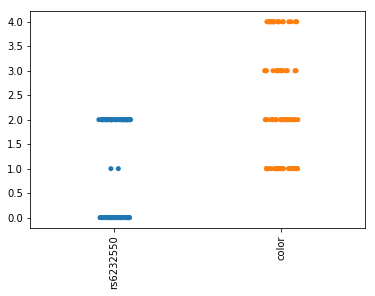

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# format plot
plt.xticks(rotation=90)

# plot
sns.stripplot(data=single.transpose(), jitter=True);
plt.show()

### Subtask: Create contingency table for a D-dominant inheritance model of black coat color and SNP rs6232550
Tip: pandas' crosstab functionality may be helpful here and the [reshaping/crosstab documentation](http://pandas-docs.github.io/pandas-docs-travis/reshaping.html) as illustrated in [this tutorial](http://wesmckinney.com/blog/contingency-tables-and-cross-tabulations-in-pandas/) may be helpful.

Reminder: Colors and corresponding values.

|color  | value  |
|-------|--------|
| black |  4     |
| grey  |  3     |
| brown |  2     |
| dilute|  1     |

In [21]:
# transpose matrix
single_transposed = single.transpose()

# print matrix for verification
single_transposed

# apply pandas.crosstab
crosstab_matrix = pandas.crosstab(single_transposed['rs6232550']>0, single_transposed['color']==4)

crosstab_matrix

color,False,True
rs6232550,,
False,32,11
True,39,8


### Subtask: Perform $\chi^2$ square test for independence on the contingency table

In [22]:
from scipy.stats import chi2_contingency

chi2, p, dof, ex = chi2_contingency(crosstab_matrix)

print("Chi", chi2)
print("P", p)
print("Dof", dof)

cont_table = pandas.DataFrame(ex)
cont_table

Chi 0.5408591552963715
P 0.46207688261974256
Dof 1


,0,1
0,33.922222,9.077778
1,37.077778,9.922222


### Subtask: Write function to calculate odds ratio from a contingency table

In [26]:
import scipy.stats as stats

def oddsRatio(table):
    '''Usage: oddsratio, pvalue = oddsRatio(contingencyTable)'''
    return stats.fisher_exact(cont_table)

oddsratio, pvalue = oddsRatio(cont_table)

print("Odds ratio:", oddsratio)

Odds ratio: 0.8918918918918919


## Task: extend statistical method for a penetrance model in which increasing numbers of A alleles confer a trend in risk (e.g. additive or dominant)

While you can model most of the penetrance models described in the lecture in a 2x2 contingency table and thus perform a $\chi^2$ test with one degree of freedom, it may sometimes be useful to consider the full complexity of a genotype contigency table considering all three possible genotypes instead of just two (even though the latter has larger statistical power). Apart from a $\chi^2$ test with two degrees of freedom, the Cochran–Armitage trend test is commonly used in genetic association tests as this has often larger statistical power. In this case, if the exact model of penetrance is not known, an additive approach is often used. 

You can read more about basic statistical approaches in genetic association tests in the following paper:

__G. Clarke et al.       
[Basic statistical analysis in genetic case-control studies](http://www.nature.com/nprot/journal/v6/n2/full/nprot.2010.182.html)__,      
Nat. Protocols, 2011/02,     
http://dx.doi.org/10.1038/nprot.2010.182


### Subtask: Given the data you have, could you calculate this type of statistic for your data?

* If yes, please implement the creation of a contingency table and the test.
* If no, please explain why.

## Task: Refactor previous analysis steps into a function and apply to all SNPs

Things to consider:
* What information is needed as input in each round?
* Do you want to support $\chi^2$ and Cochran–Armitage test?
* What information as output is needed?
* Should multiple inheritance models be included?
* Should the user get to chose which hair color to test?

### Subtask: Create Manhattan Plot of  $-\log_{10}(\text{P-value})$ vs chromosome position 
A Manhattan plot, named after its resemblance to the skyline of Manhattan, is commonly used to plot the p-value obtained for individual association tests for each SNP compared to the SNP's position on the genome as shown in the example below.

Technically, a Manhattan plot is a scatter plot of genome position (for each chromosome) vs the negative logarithm of the p-value.

Try to approximate the following plot as closely as possible:

<img src='Manhattan.png'>

#### Bonus if you have way too much time: Try to make plot interactive (e.g. add tooltips on hover using mpld3)

hint: http://mpld3.github.io/examples/html_tooltips.html

In [15]:
# import mpld3

In [16]:
# necessary to make it work in notebook
mpld3.disable_notebook()

NameError: name 'mpld3' is not defined

### Subtask: If you have time, try to implement alternative inheritance models

## Task: Correct for Multiple Hypothesis Testing

Employ one of the correction methods described in the lecture to take care of the multiple hypothesis testing.

In [ ]:
from statsmodels.sandbox.stats.multicomp import multipletests

### Subtask: Wrap your MHT correction in a function
Ideally, the function should allow easy access to several parameters including the target $\alpha$ and the correction method

### Subtask: Test if the function works as intended

## Task: Identify candidate genes from identified loci

### Subtask: Identify genes in region identified by significant loci (consider each chromosome separately)

What we identified so far are so called __quantitative trait loci__, meaning that this locus on the genome is associated with a quantitative trait. This does not mean there is directly a causal relationship between the markers identified in the association study and the phenotype. It is, however, a pointer towards the region of the genome that may be relevant for the variability in the measured trait. The genes encompassed in this region then need to be analysed further to identify viable mechanistic candidates.



A good starting point for this fine grained analysis would be to look up the genes directly linked to the SNP in dbSNP  (e.g, http://www.ncbi.nlm.nih.gov/projects/SNP/snp_ref.cgi?rs=rs3674482).

Most likely the high ranking SNPs will not map directly to the causal gene, but will rather be a marker for another variant in a gene in __linkage disequilibrium__ with this this SNP. We thus need to extend the search and look at other genes in the vicinity of the high ranking SNPs.

You may thus want to move on the [Biomart](http://www.ensembl.org/biomart/martview/fb0e89930dcbbdb8075ca52f8b196719) to query for genes in a genomic region.

A third resource you may want to check out is the [UCSC Genome Browser](http://genome.ucsc.edu/) for visual explorations as well as the [UCSC Table Browser](http://genome.ucsc.edu/cgi-bin/hgTables?hgsid=511555905_oFRLEcH1IWO1FdKyzynrsBCRMk7w) to obtain genes in a genomic region. The identifiers of proteins in the [uniprot](http://www.uniprot.org/) database are listed in the resulting table. Uniprot then can provide useful annotations of the proteins found in the search frame.

Programmatic access is possible for all the services above using their REST interfaces:  

[UCSC](http://genomewiki.ucsc.edu/index.php/Programmatic_access_to_the_Genome_Browser)     
[Biomart](http://www.ensembl.org/info/data/biomart/biomart_restful.html)     
[Uniprot](http://www.uniprot.org/help/programmatic_access)     

There have been multiple attempts to make it possible to query these services using python directly. The most important packages are:  

[bioservices](https://pythonhosted.org/bioservices/)      
[biomart-python](https://github.com/sebriois/biomart)      

An example on how to query uniprot using bioservices can be found in [this notebook](http://nbviewer.jupyter.org/url/pythonhosted.org/bioservices/\_downloads/UniProt.ipynb).

If you decide to search for the genes of interest based on the genome location, make sure to select the correct reference genome. The reference used for the BXD genotyping is described in the genotype description on [genenetwork.org](http://www.genenetwork.org/dbdoc/BXDGeno.html)

### Subtask: Check if the locations you found match to what is known from literature about genetics of mouse coat color

# Association tests between variant(s) and continuous phenotype¶ 
All of the phenotype data provided in the multi-omics publication is actually not categorical. We thus have to adapt our approach to use continuous data. In the lecture you learned that instead of $\chi^2$ test or logistic regression, linear regression models or correlation tests could be used. 

## Task: Import relevant functions from scipy

## Task: Load Phenotype spreadsheets from paper supplement

## Task: Implement Pearson's r-based test for correlation in the context of our data

## Task: Plot corresponding Manhattan Plot (using your previously defined function)

## Task: Correct for multiple hypothesis testing

# Run association tests for all phenotypes in Biochemistry, Hematology, and Blood Pressure
Moving now into phenotype association studies, we will now test multiple phenotypes for genetic associations. To determine how much each trait is associated with a genetic factor, we have to repeat our analyses for (ideally all) phenotypes of interest while correcting for multiple hypothesis testing. We then have to figure out which traits are the most associated.

Make sure to consider significance of association as well as the effect size of the association.

Which traits are most influenced by genetics?

## Task: Pick a testing method from the previous tasks that is applicable for the  phenotype variable type

## Task: Iteratively apply functionality to all phenotypes

## Task: Extract relevant information about effect size, significance, locus,...

## Task: Interpret results

## Task: For most interesting examples, try to identify possible candidate genes

## Task: Compare your results to literature

## What confounding factors may have been ignored in the current approach? How could they be incorporated?